In [94]:
import joblib
from joblib import dump
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, r2_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [95]:
# Load datasets
housing_data = pd.read_csv('Datasets/housing.csv')
crime_data = pd.read_csv('Datasets/crimes_by_state.csv')

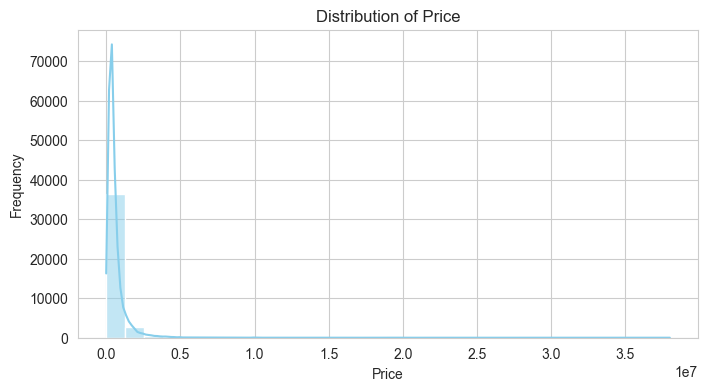

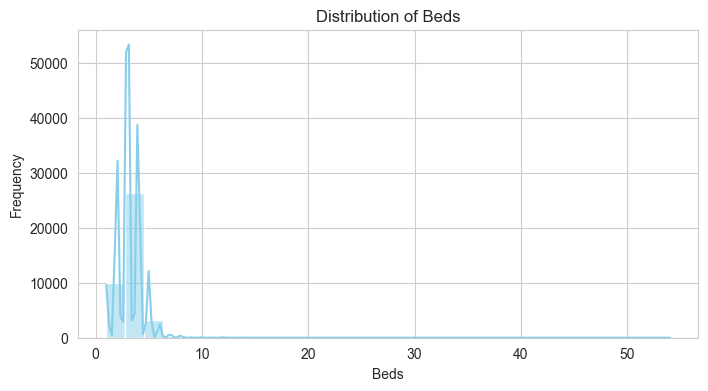

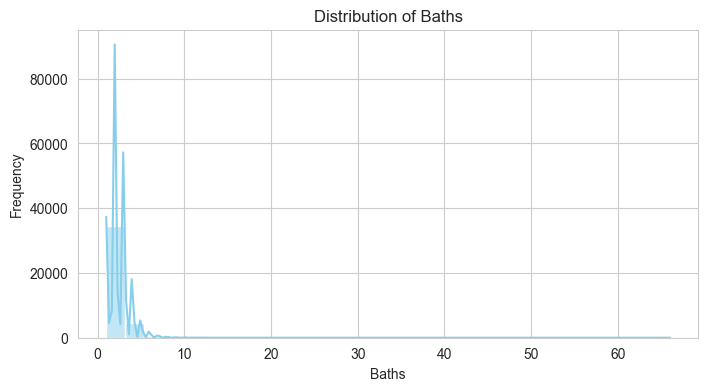

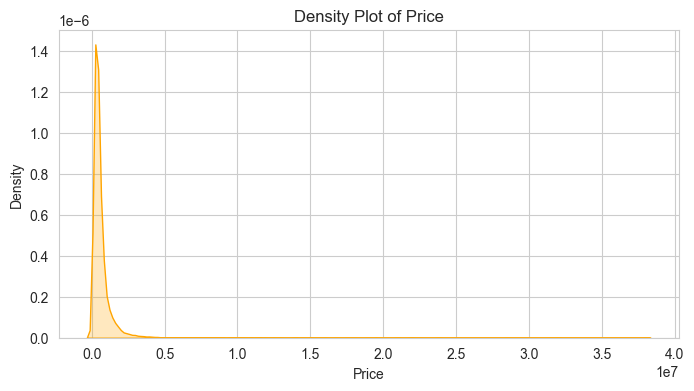

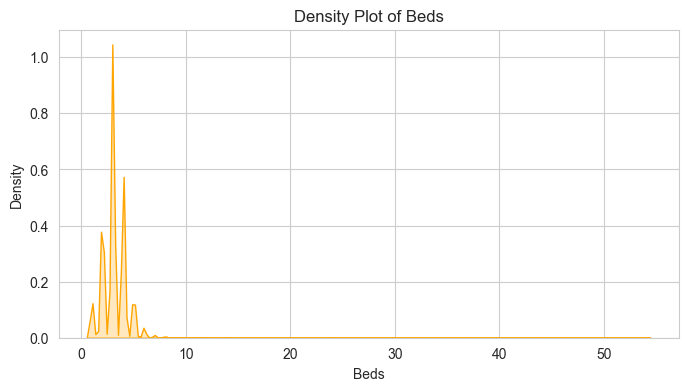

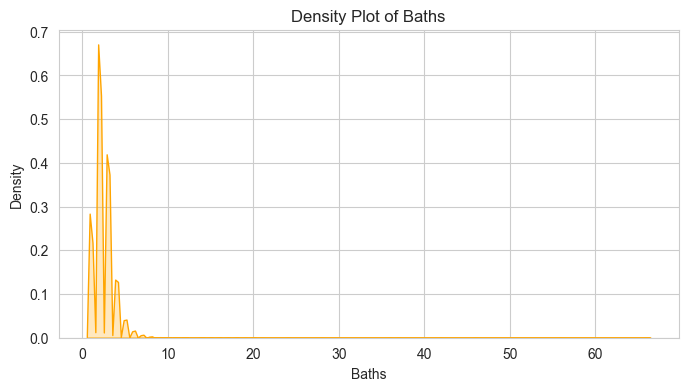

In [96]:
# List of numerical features
numerical_features = ['price', 'beds', 'baths']

# Histograms
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(housing_data[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.show()

# Density Plots
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(housing_data[feature], fill=True, color='orange')
    plt.title(f'Density Plot of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Density')
    plt.show()

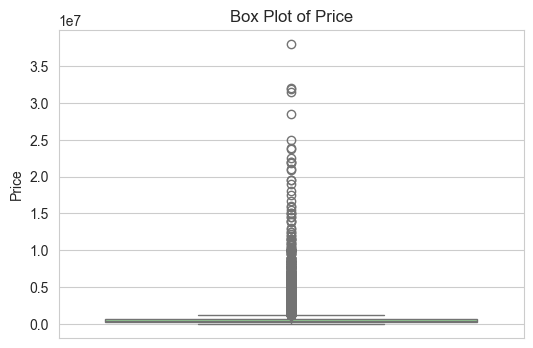

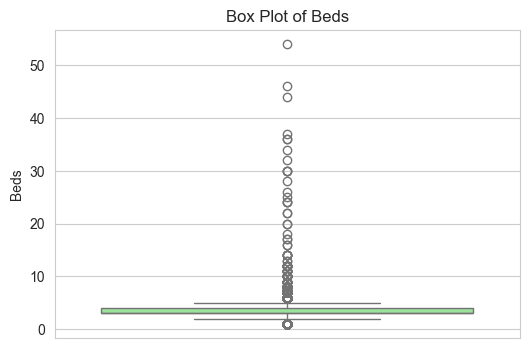

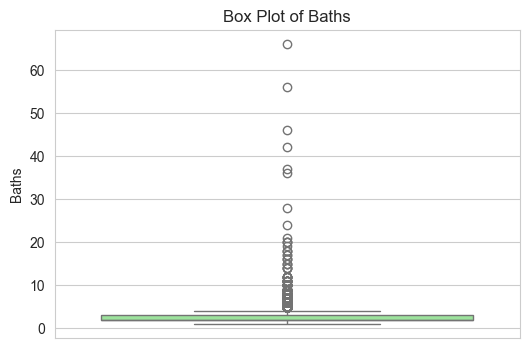

In [97]:
for feature in ['price', 'beds', 'baths']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=housing_data[feature], color='lightgreen')
    plt.title(f'Box Plot of {feature.capitalize()}')
    plt.ylabel(feature.capitalize())
    plt.show()

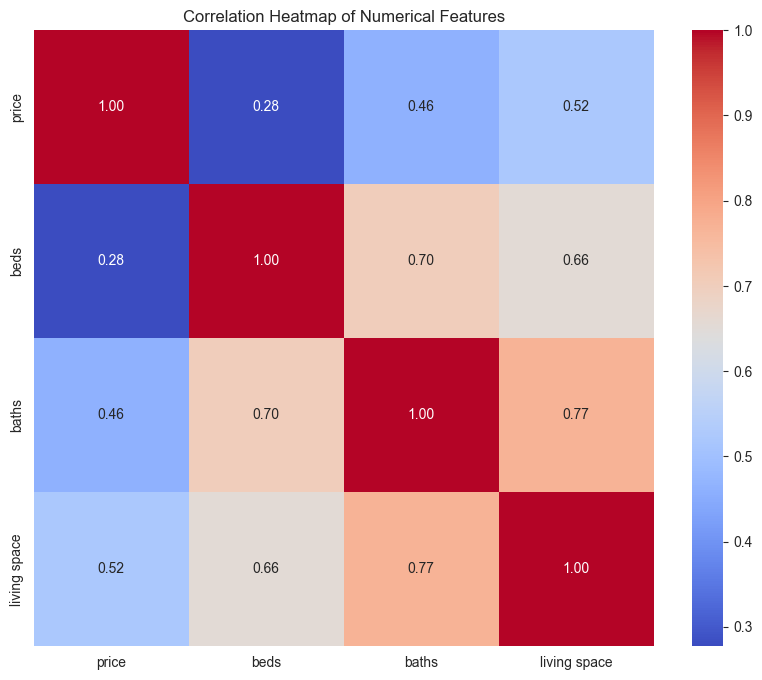

In [98]:
numerical_features = ['price', 'beds', 'baths', 'living space']
plt.figure(figsize=(10, 8))
corr_matrix = housing_data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [99]:
# Data Cleaning

# Dropping irrelevant columns
housing_data = housing_data.drop(columns=['zip code', 'address', 'zip code density', 'county', 'latitude', 'longitude'])

# Identifying numerical and categorical columns
numerical_cols = housing_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = housing_data.select_dtypes(include=['object']).columns.tolist()

# Handling missing values
# Impute numerical columns with median
num_imputer = SimpleImputer(strategy='median')
housing_data[numerical_cols] = num_imputer.fit_transform(housing_data[numerical_cols])

# Impute categorical columns with most frequent
if categorical_cols:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    housing_data[categorical_cols] = cat_imputer.fit_transform(housing_data[categorical_cols])

# Remove outliers using IQR for 'price', 'beds', and 'baths'
for col in ['price', 'beds', 'baths']:
    Q1 = housing_data[col].quantile(0.25)
    Q3 = housing_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    housing_data = housing_data[(housing_data[col] >= lower_bound) & (housing_data[col] <= upper_bound)]

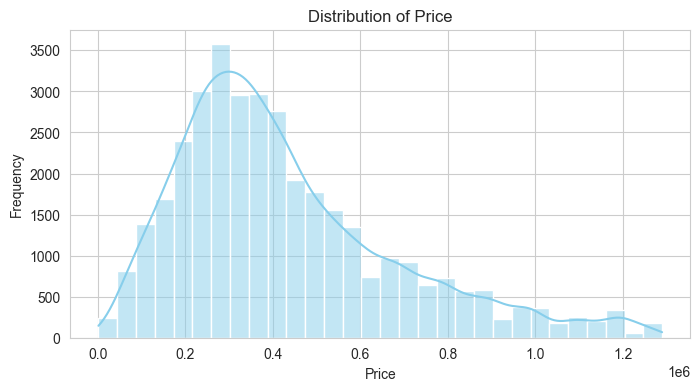

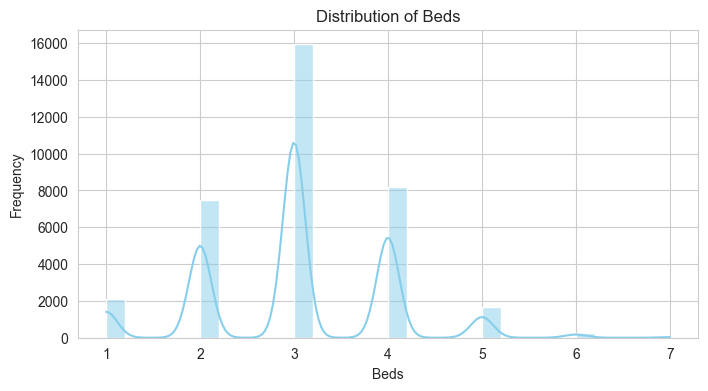

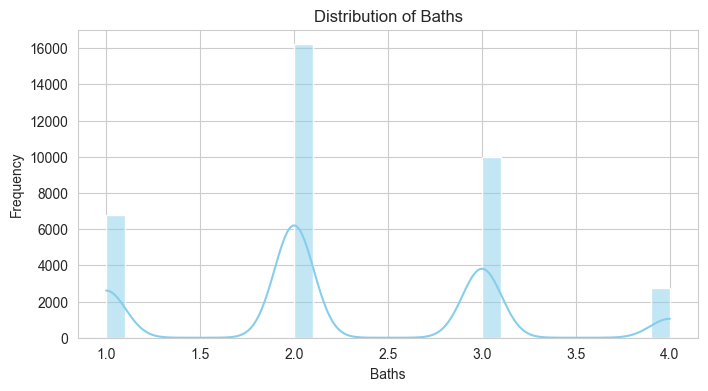

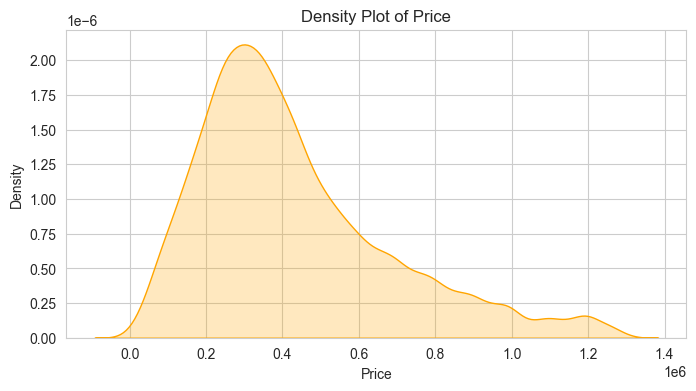

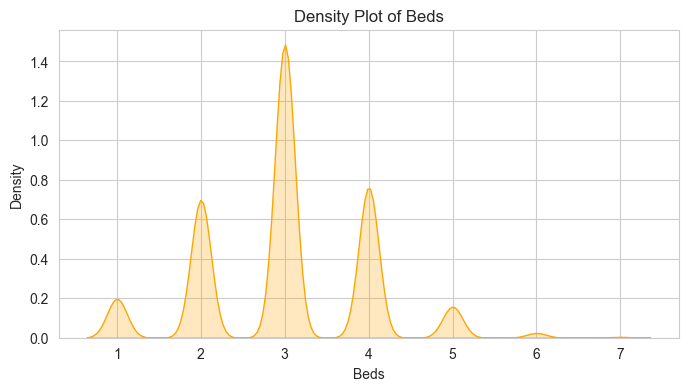

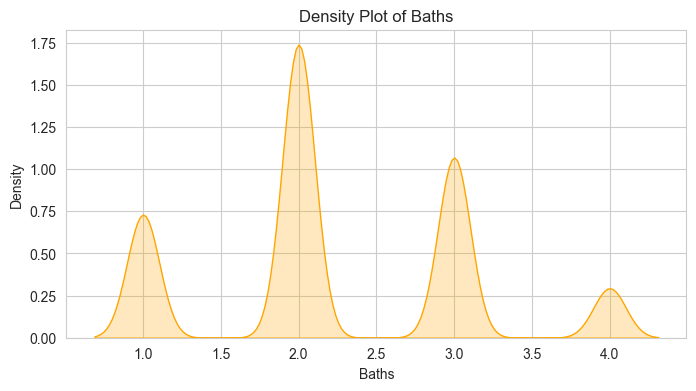

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical features
numerical_features = ['price', 'beds', 'baths']

# Histograms
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(housing_data[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.show()

# Density Plots
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(housing_data[feature], fill=True, color='orange')
    plt.title(f'Density Plot of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Density')
    plt.show()

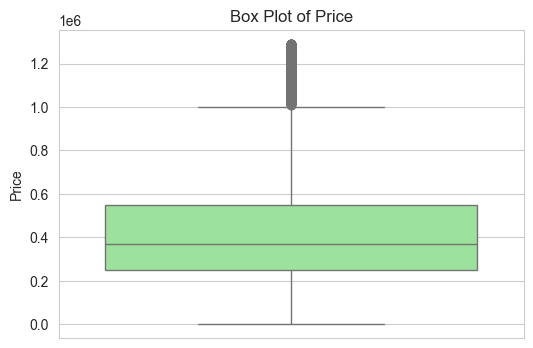

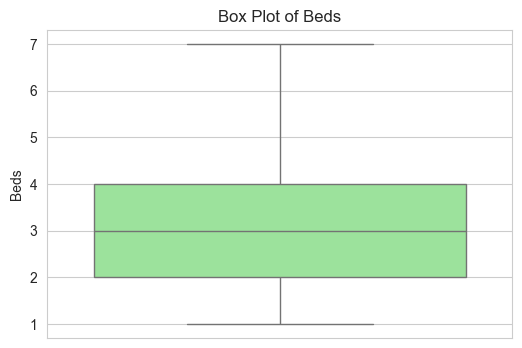

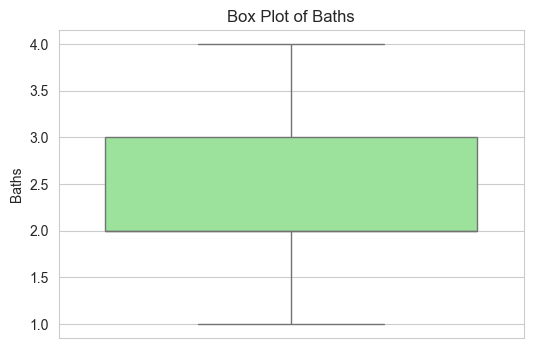

In [101]:
for feature in ['price', 'beds', 'baths']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=housing_data[feature], color='lightgreen')
    plt.title(f'Box Plot of {feature.capitalize()}')
    plt.ylabel(feature.capitalize())
    plt.show()

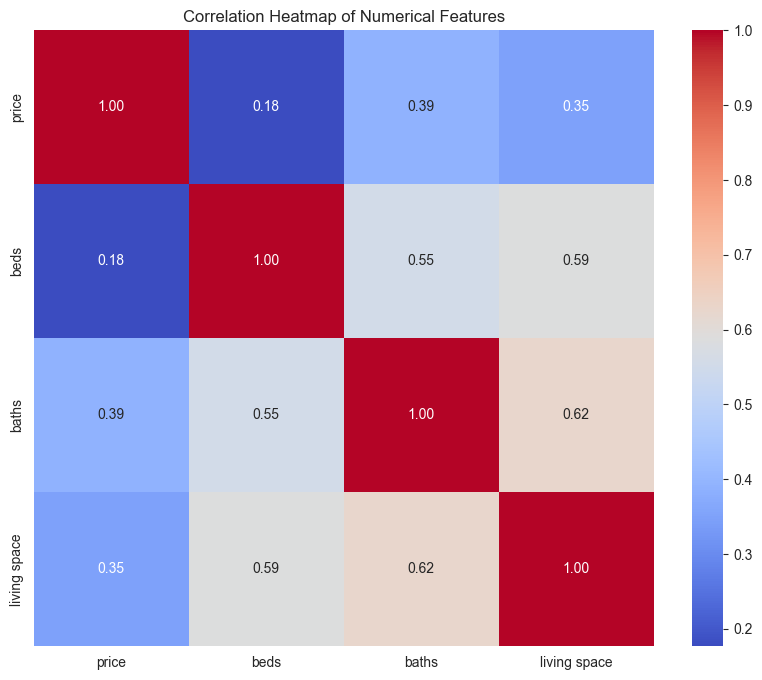

In [102]:
numerical_features = ['price', 'beds', 'baths', 'living space']
plt.figure(figsize=(10, 8))
corr_matrix = housing_data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

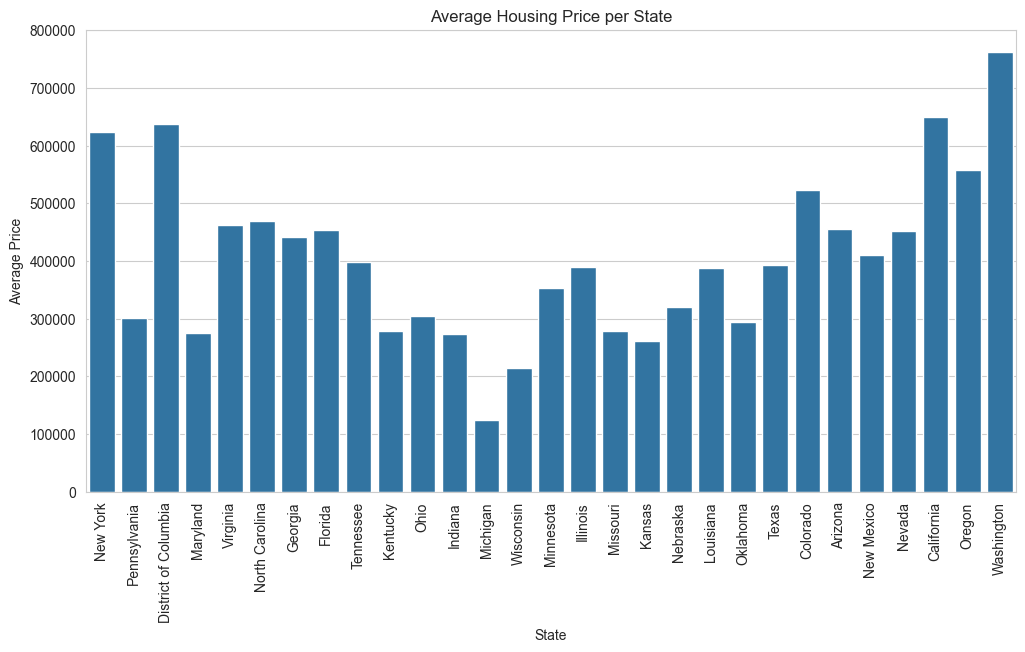

In [103]:
# Bar plot: Average Price per State
plt.figure(figsize=(12,6))
sns.barplot(x='state', y='price', data=housing_data,errorbar=None)
plt.title('Average Housing Price per State')
plt.xlabel('State')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

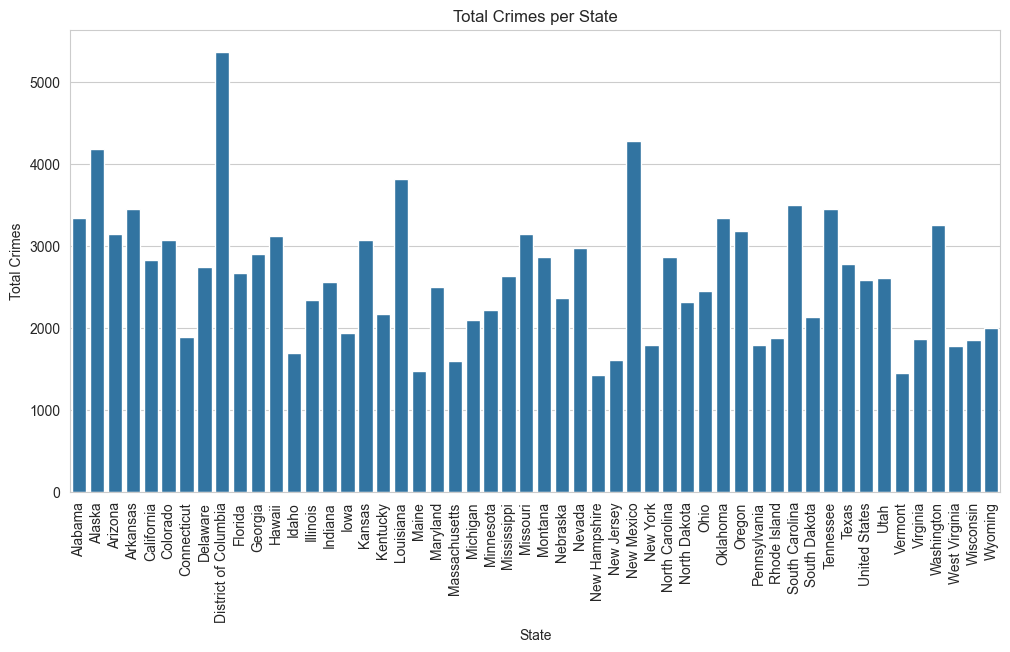

In [104]:
# Bar plot: Average Price per State
total_crimes = crime_data['property_per_100_000']+crime_data['violence_per_100_000']

plt.figure(figsize=(12,6))
sns.barplot(x='state', y=total_crimes, data=crime_data, errorbar=None)
plt.title('Total Crimes per State')
plt.xlabel('State')
plt.ylabel('Total Crimes')
plt.xticks(rotation=90)
plt.show()

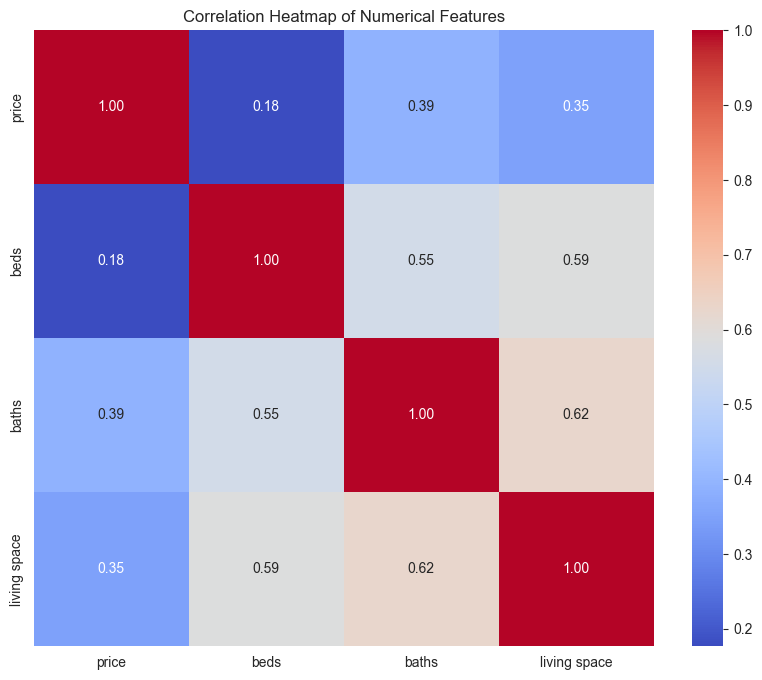

In [105]:
plt.figure(figsize=(10, 8))
corr_matrix = housing_data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [106]:
# Merge with crime data
housing_data = housing_data.merge(crime_data, how='left', on='state')

# Feature Engineering: Create 'Affordability' feature
def calculate_affordability(price, median_income, interest_rate=0.06, years=30):
    # Calculate monthly interest rate
    r = interest_rate / 12
    n = years * 12

    # Calculate monthly mortgage payment using the formula
    monthly_payment = price * (r * (1 + r) ** n) / ((1 + r) ** n - 1)

    # Calculate 30% of monthly household income
    affordable_payment = (median_income / 12) * 0.30

    # Check if the house is affordable
    return monthly_payment <= affordable_payment

# Apply this logic to each row in the dataset
housing_data['affordability'] = housing_data.apply(
    lambda row: calculate_affordability(row['price'], row['median household income']),
    axis=1
)

In [107]:
# Define features and targets
X = housing_data.drop(columns=['price', 'affordability'])
y_reg = housing_data['price']
y_cls = housing_data['affordability']

In [108]:
# Split the data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls, test_size=0.2, random_state=42)

In [109]:
# Preprocessing Pipelines

# Numerical features
numeric_features = ['beds', 'baths', 'property_per_100_000', 'violence_per_100_000']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [110]:
# Categorical features
categorical_features = ['state']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

In [111]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [112]:
# Pipeline for Random Forest Regression
rf_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [113]:
# Hyperparameter Tuning for Random Forest Regression Model
rf_param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(rf_reg_pipeline, rf_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train_reg, y_train_reg)

best_rf_regressor = rf_grid_search.best_estimator_
y_pred_rf_reg = best_rf_regressor.predict(X_test_reg)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [22]:
# Evaluation Metrics for Random Forest Regression
rf_mse = mean_squared_error(y_test_reg, y_pred_rf_reg)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test_reg, y_pred_rf_reg)
rf_r2 = r2_score(y_test_reg, y_pred_rf_reg)

print('--- Random Forest Regression Metrics ---')
print(f'Mean Squared Error (MSE): {rf_mse}')
print(f'Root Mean Squared Error (RMSE): {rf_rmse}')
print(f'Mean Absolute Error (MAE): {rf_mae}')
print(f'R² Score: {rf_r2}')

--- Random Forest Regression Metrics ---
Mean Squared Error (MSE): 33915014782.37007
Root Mean Squared Error (RMSE): 184160.29643321622
Mean Absolute Error (MAE): 132730.74662927474
R² Score: 0.47229746164994324


In [23]:
# Pipeline for Linear Regression
lr_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit Linear Regression Model
lr_reg_pipeline.fit(X_train_reg, y_train_reg)
y_pred_lr_reg = lr_reg_pipeline.predict(X_test_reg)

# Evaluation Metrics for Linear Regression
lr_mse = mean_squared_error(y_test_reg, y_pred_lr_reg)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test_reg, y_pred_lr_reg)
lr_r2 = r2_score(y_test_reg, y_pred_lr_reg)

In [24]:
print('\n--- Linear Regression Metrics ---')
print(f'Mean Squared Error (MSE): {lr_mse}')
print(f'Root Mean Squared Error (RMSE): {lr_rmse}')
print(f'Mean Absolute Error (MAE): {lr_mae}')
print(f'R² Score: {lr_r2}')


--- Linear Regression Metrics ---
Mean Squared Error (MSE): 35589969401.961365
Root Mean Squared Error (RMSE): 188653.03973687082
Mean Absolute Error (MAE): 138141.41824003524
R² Score: 0.4462359130983282


In [25]:
# Compare Regression Models
comparison_df = pd.DataFrame({
    'Model': ['Random Forest Regressor', 'Linear Regression'],
    'MSE': [rf_mse, lr_mse],
    'RMSE': [rf_rmse, lr_rmse],
    'MAE': [rf_mae, lr_mae],
    'R² Score': [rf_r2, lr_r2]
})

print('\n--- Regression Model Comparison ---')
print(comparison_df)


--- Regression Model Comparison ---
                     Model           MSE           RMSE            MAE  \
0  Random Forest Regressor  3.391501e+10  184160.296433  132730.746629   
1        Linear Regression  3.558997e+10  188653.039737  138141.418240   

   R² Score  
0  0.472297  
1  0.446236  


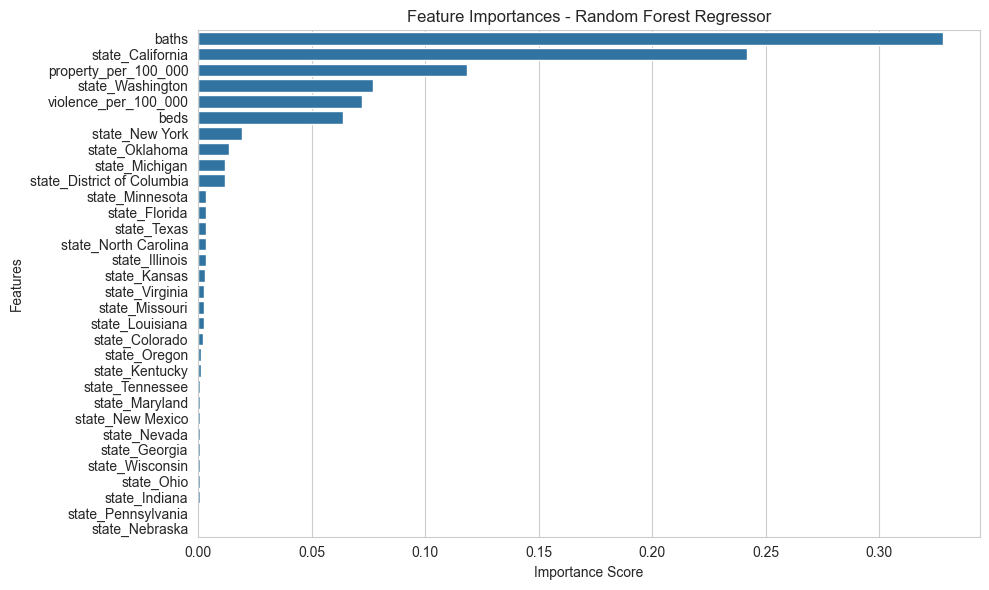

In [26]:

# Feature Importance for Random Forest Regressor
if hasattr(best_rf_regressor.named_steps['regressor'], 'feature_importances_'):
    importances = best_rf_regressor.named_steps['regressor'].feature_importances_
    # Get feature names after one-hot encoding
    num_features = best_rf_regressor.named_steps['preprocessor'].transformers_[0][2]
    cat_encoder = best_rf_regressor.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
    cat_features = list(cat_encoder.get_feature_names_out(categorical_features))
    feature_names = num_features + cat_features
    feature_importances = pd.Series(importances, index=feature_names)
    feature_importances.sort_values(ascending=False, inplace=True)

    # Plot Feature Importances
    plt.figure(figsize=(10,6))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title('Feature Importances - Random Forest Regressor')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [86]:
# Pipeline for Classification
cls_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [87]:
# Hyperparameter Tuning for Classification Model
param_grid_cls = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs']
}

grid_search_cls = GridSearchCV(cls_pipeline, param_grid_cls, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_cls.fit(X_train_cls, y_train_cls)

best_classifier = grid_search_cls.best_estimator_
y_pred_cls = best_classifier.predict(X_test_cls)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [88]:
# Evaluation Metrics for Classification
accuracy = accuracy_score(y_test_cls, y_pred_cls)
conf_matrix = confusion_matrix(y_test_cls, y_pred_cls)
report = classification_report(y_test_cls, y_pred_cls)

print('\n--- Classification Metrics ---')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(report)


--- Classification Metrics ---
Accuracy: 0.7489147178266349
Confusion Matrix:
[[1855 1108]
 [ 685 3493]]
Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.63      0.67      2963
        True       0.76      0.84      0.80      4178

    accuracy                           0.75      7141
   macro avg       0.74      0.73      0.73      7141
weighted avg       0.75      0.75      0.75      7141



In [30]:
# Function to predict price
def predict_house_price(state, bedrooms, baths):
    try:
        # Retrieve crime statistics for the state
        crime_stats = crime_data.loc[crime_data['state'] == state]
        if crime_stats.empty:
            return "State not found in dataset."

        property_crime = crime_stats['property_per_100_000'].values[0]
        violence_crime = crime_stats['violence_per_100_000'].values[0]

        # Create input DataFrame for prediction
        input_data = pd.DataFrame({
            'beds': [bedrooms],
            'baths': [baths],
            'property_per_100_000': [property_crime],
            'violence_per_100_000': [violence_crime],
            'state': [state]
        })

        # Predict using the best Random Forest regression pipeline
        predicted_price_rf = best_rf_regressor.predict(input_data)[0]
        # Predict using the Linear Regression pipeline
        predicted_price_lr = lr_reg_pipeline.predict(input_data)[0]

        return (f'Predicted Price (Random Forest): ${predicted_price_rf:,.2f}\n'
                f'Predicted Price (Linear Regression): ${predicted_price_lr:,.2f}')
    except Exception as e:
        return f"Error in prediction: {e}"

# Example usage
predicted_price = predict_house_price('New York', 2, 1)
print('\n--- Prediction Example ---')
print(predicted_price)


--- Prediction Example ---
Predicted Price (Random Forest): $453,513.11
Predicted Price (Linear Regression): $510,474.28


In [42]:
median_household_income = 0

def calculate_affordability(price, median_income, interest_rate=0.06, years=30):
    r = interest_rate / 12  # Monthly interest rate
    n = years * 12  # Total number of payments

    # Calculate monthly mortgage payment
    monthly_payment = price * (r * (1 + r) ** n) / ((1 + r) ** n - 1)

    # Calculate 30% of monthly household income
    affordable_payment = (median_income / 12) * 0.30

    return monthly_payment <= affordable_payment, monthly_payment

def predict_house_price(state, bedrooms, baths):
    try:
        # Retrieve crime statistics and median household income for the state
        crime_stats = crime_data.loc[crime_data['state'] == state]
        if crime_stats.empty:
            return "State not found in dataset."

        median_income = housing_data.loc[housing_data['state'] == state, 'median household income'].values[0]
        median_household_income = median_income
        property_crime = crime_stats['property_per_100_000'].values[0]
        violence_crime = crime_stats['violence_per_100_000'].values[0]

        # Create input DataFrame for prediction
        input_data = pd.DataFrame({
            'beds': [bedrooms],
            'baths': [baths],
            'property_per_100_000': [property_crime],
            'violence_per_100_000': [violence_crime],
            'state': [state]
        })

        # Predict using the best Random Forest regression pipeline
        predicted_price_rf = best_rf_regressor.predict(input_data)[0]

        # Calculate affordability
        is_affordable, monthly_payment = calculate_affordability(predicted_price_rf, median_income)

        # Prepare the result string
        affordability_status = "Affordable" if is_affordable else "Not Affordable"

        return (f'Predicted Price (Random Forest): ${predicted_price_rf:,.2f}\n'
                f'Median Household Income/Year: ${median_household_income:,.2f}\n'
                f'Monthly Payment: ${monthly_payment:,.2f}\n'
                f'Affordability Status: {affordability_status}')
    except Exception as e:
        return f"Error in prediction: {e}"

# Example usage
predicted_price = predict_house_price('New York', 5, 4)
print(predicted_price)

Predicted Price (Random Forest): $1,122,871.23
Median Household Income/Year: $249,880.00
Monthly Payment: $6,732.18
Affordability Status: Not Affordable


In [54]:
def can_afford_home(state, bedrooms, baths, annual_salary_after_tax):
    try:
        # Retrieve crime statistics for the state
        crime_stats = crime_data.loc[crime_data['state'] == state]
        if crime_stats.empty:
            return "State not found in dataset."

        # Calculate median monthly income from annual salary
        median_income = annual_salary_after_tax

        property_crime = crime_stats['property_per_100_000'].values[0]
        violence_crime = crime_stats['violence_per_100_000'].values[0]

        # Create input DataFrame for price prediction
        input_data = pd.DataFrame({
            'beds': [bedrooms],
            'baths': [baths],
            'property_per_100_000': [property_crime],
            'violence_per_100_000': [violence_crime],
            'state': [state]
        })

        # Predict house price using the best Random Forest regression pipeline
        predicted_price_rf = best_rf_regressor.predict(input_data)[0]

        # Calculate monthly mortgage payment
        is_affordable, monthly_payment = calculate_affordability(predicted_price_rf, median_income)

        # Check affordability status
        affordability_status = "Affordable" if is_affordable else "Not Affordable"

        return (f'Predicted Price (Random Forest): ${predicted_price_rf:,.2f}\n'
                f'Monthly Payment: ${monthly_payment:,.2f}\n'
                f'Affordability Status: {affordability_status}')
    except Exception as e:
        return f"Error in determining affordability: {e}"

# Example usage
result = can_afford_home('New York', 3, 2, 200000)  # Annual salary of $80,000 after tax
print(result)

Predicted Price (Random Forest): $659,209.25
Monthly Payment: $3,952.29
Affordability Status: Affordable


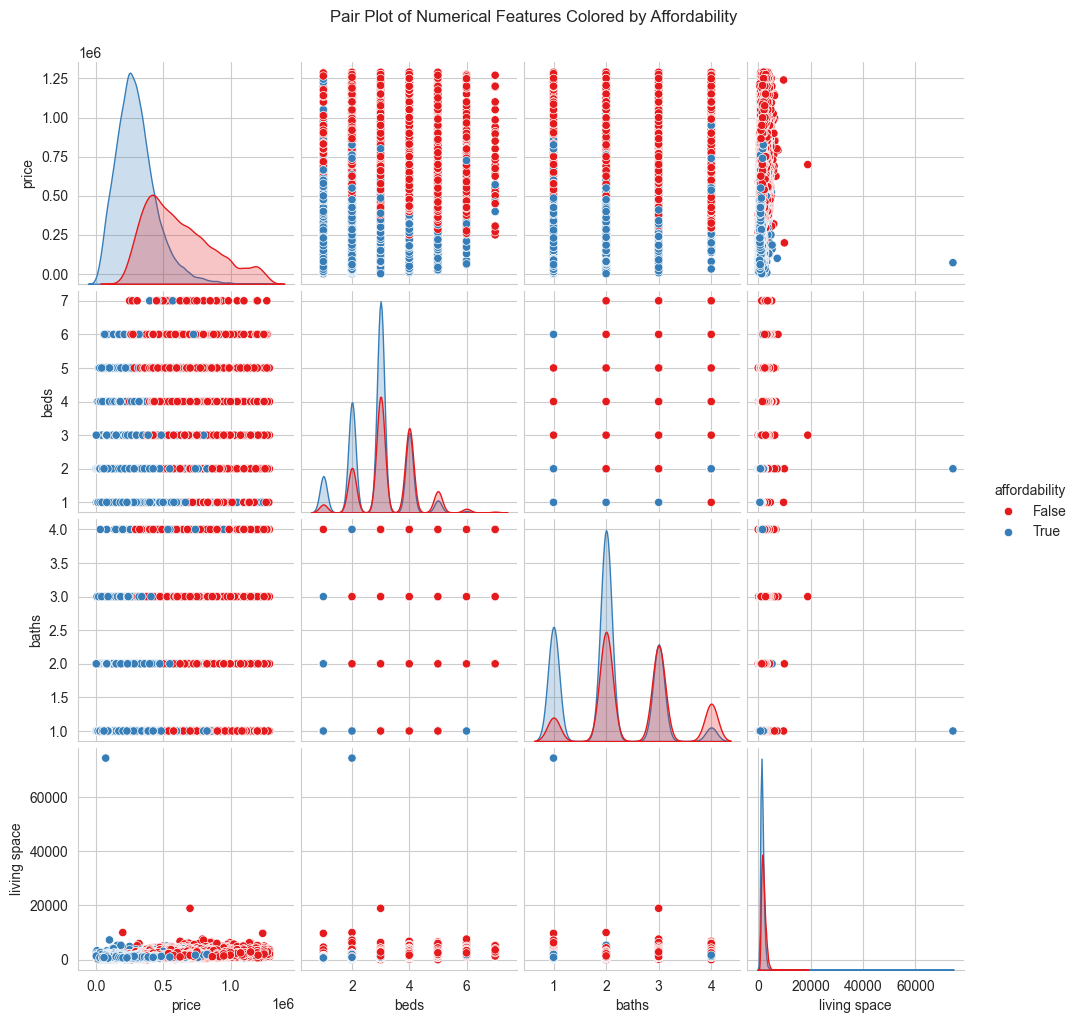

In [39]:
sns.pairplot(housing_data[numerical_features + ['affordability']], hue='affordability', palette='Set1', diag_kind='kde')
plt.suptitle('Pair Plot of Numerical Features Colored by Affordability', y=1.02)
plt.show()

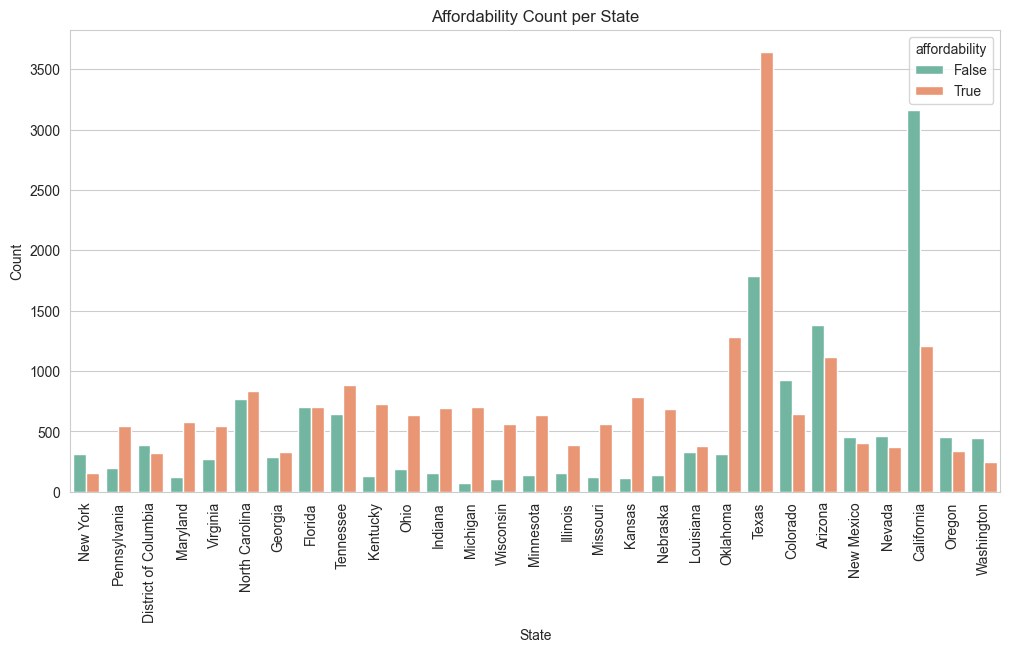

In [90]:
# Count plot: Affordability per State
plt.figure(figsize=(12,6))
sns.countplot(x='state', hue='affordability', data=housing_data, palette='Set2')
plt.title('Affordability Count per State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [68]:
def predict_house_price(state, bedrooms, baths):
    try:
        # Retrieve crime statistics for the state
        crime_stats = crime_data.loc[crime_data['state'] == state]
        if crime_stats.empty:
            return "State not found in dataset."

        property_crime = crime_stats['property_per_100_000'].values[0]
        violence_crime = crime_stats['violence_per_100_000'].values[0]

        # Create input DataFrame for prediction
        input_data = pd.DataFrame({
            'beds': [bedrooms],
            'baths': [baths],
            'property_per_100_000': [property_crime],
            'violence_per_100_000': [violence_crime],
            'state': [state]
        })

        # Predict using the best Random Forest regression pipeline
        predicted_price_rf = best_rf_regressor.predict(input_data)[0]

        return f'Predicted Price: ${predicted_price_rf:,.2f}'
    except Exception as e:
        return f"Error in prediction: {e}"

In [69]:
# Example usage
predicted_price = predict_house_price('New York', 1, 1)
print(predicted_price)

Predicted Price: $372,952.74


In [70]:
# Example usage
predicted_price = predict_house_price('New York', 2, 1)
print(predicted_price)

Predicted Price: $453,513.11


In [71]:
# Example usage
predicted_price = predict_house_price('New York', 3, 1)
print(predicted_price)

Predicted Price: $617,282.36


In [72]:
# Example usage
predicted_price = predict_house_price('New York', 3, 2)
print(predicted_price)

Predicted Price: $659,209.25


In [73]:
# Example usage
predicted_price = predict_house_price('New York', 4, 2)
print(predicted_price)

Predicted Price: $789,245.36


In [74]:
# Example usage
predicted_price = predict_house_price('California', 1, 1)
print(predicted_price)

Predicted Price: $532,732.39


In [75]:
# Example usage
predicted_price = predict_house_price('California', 2, 1)
print(predicted_price)

Predicted Price: $568,363.72


In [76]:
# Example usage
predicted_price = predict_house_price('California', 3, 1)
print(predicted_price)

Predicted Price: $561,623.92


In [77]:
# Example usage
predicted_price = predict_house_price('California', 3, 2)
print(predicted_price)

Predicted Price: $628,254.78


In [78]:
# Example usage
predicted_price = predict_house_price('California', 4, 2)
print(predicted_price)

Predicted Price: $677,246.69


In [79]:
# Example usage
predicted_price = predict_house_price('Texas', 1, 1)
print(predicted_price)

Predicted Price: $246,153.83


In [80]:
# Example usage
predicted_price = predict_house_price('Texas', 2, 1)
print(predicted_price)

Predicted Price: $266,023.50


In [81]:
# Example usage
predicted_price = predict_house_price('Texas', 3, 1)
print(predicted_price)

Predicted Price: $263,805.23


In [82]:
# Example usage
predicted_price = predict_house_price('Texas', 3, 2)
print(predicted_price)

Predicted Price: $329,137.53


In [83]:
# Example usage
predicted_price = predict_house_price('Texas', 4, 2)
print(predicted_price)

Predicted Price: $318,113.05


In [84]:
# Example usage
predicted_price = predict_house_price('California', 5, 4)
print(predicted_price)

Predicted Price: $726,577.27


In [92]:
joblib.dump(best_rf_regressor, 'random_forest_model_for_house_price_prediction.joblib')

['random_forest_model_for_house_price_prediction.joblib']

In [66]:
def classify_affordability(state, bedrooms, baths, annual_income_after_tax):
    try:
        # Retrieve crime statistics for the state
        crime_stats = crime_data.loc[crime_data['state'] == state]
        if crime_stats.empty:
            return "State not found in dataset."

        property_crime = crime_stats['property_per_100_000'].values[0]
        violence_crime = crime_stats['violence_per_100_000'].values[0]

        # Create input DataFrame for price prediction
        input_data = pd.DataFrame({
            'beds': [bedrooms],
            'baths': [baths],
            'property_per_100_000': [property_crime],
            'violence_per_100_000': [violence_crime],
            'state': [state]
        })

        # Predict house price using the Random Forest regression pipeline
        predicted_price_rf = best_rf_regressor.predict(input_data)[0]

        # Calculate monthly mortgage payment
        is_affordable, monthly_payment = calculate_affordability(predicted_price_rf, annual_income_after_tax)

        # Check affordability status
        affordability_status = "Affordable" if is_affordable else "Not Affordable"

        # Format the output
        return (f'Predicted Price (Random Forest): ${predicted_price_rf:,.2f}\n'
                f'Yearly Income: ${annual_income_after_tax:,.2f}\n'
                f'Monthly Payment: ${monthly_payment:,.2f}\n'
                f'Affordability Status: {affordability_status}')

    except Exception as e:
        return f"Error in affordability classification: {e}"

# Example usage
result = classify_affordability('California', 5, 4, 1000000)  # Annual income of $249,880
print(result)

Predicted Price (Random Forest): $726,577.27
Yearly Income: $1,000,000.00
Monthly Payment: $4,356.20
Affordability Status: Affordable


In [91]:
joblib.dump(best_classifier, 'classification_model.joblib')

['classification_model.joblib']

In [93]:
joblib.dump(lr_reg_pipeline, 'linear_regression_model_for_house_price_prediction.joblib')

['linear_regression_model_for_house_price_prediction.joblib']